<a href="https://colab.research.google.com/github/marlapinkert/TEWA2/blob/main/03_Neuroimaging_File_Formats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 03 - Neuroimaging File Formats




Understanding MRI data can be tricky. Last session, we learned how MRI data is represented on our computers. Here, we'll have a look at how this MRI data gets from the scanner to the computer, how it is stored and how we can make sense of it. For this, we will use the command line & a Nipype interface.

Also, since the DataCamp tutorials did not include this, we will look into object-oriented programming.

*Questions*

- How is MRI data stored?
- How can we convert different file formats (using the command line)?
- What are objects in Python?
- What are Nipype interfaces? What's the difference to using the command line?

*Objective*

- Convert DICOM files to NIfTI (both using the command line and Nipype)

---

## Overview of neuroimaging file formats

There are different file formats to store MRI data. The most common ones are:

- **DICOM (.dcm)**:            Digital Imaging and Communications in Medicine
- **NIfTI (.nii or .nii.gz)**: Neuroimaging Informatics Technology Initiative
- **Analyze (.img and .hdr)**
- **Minc (.minc)**

For most scanners, images are initally collected in the DICOM format. Importantly, DICOM saves one file per slice. Thus, a prolonged scanning sessions may result in hundreds or thousands of single files. This is how it looks (note that every file is named with a unique identifier):

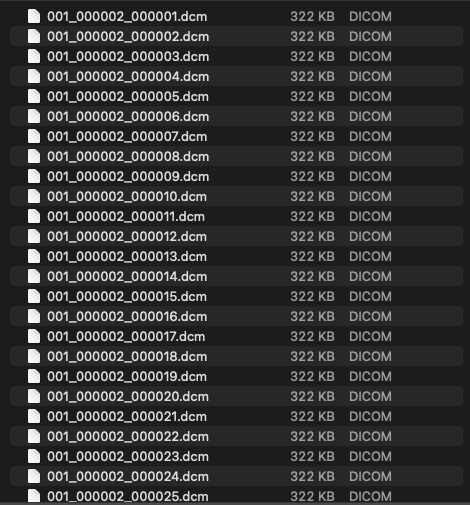

Performing complex operations on the MRI data, however, can be complicated with thousands of single files. That's why it's common to convert the DICOM files to a single NIfTI file as first step of data processing. One tool that can be used for this job is ```dcm2niix```. More information can be found [here](https://github.com/rordenlab/dcm2niix).

## Converting between neuroimaging file formats

### Setting up the environment

If you're running this notebook on Google colab, you can download a sample dicom dataset (downloaded from [here](https://wiki.idoimaging.com/index.php?title=Sample_Data)) and install ```dcm2niix``` by executing the two cells below (note that the ```!``` indicates a shell command)

In [2]:
# download dicom data
!mkdir /content/dicomdata
!wget https://data.idoimaging.com/dicom/1010_brain_mr/1010_brain_mr_02_lee.zip --no-check-certificate
!unzip 1010_brain_mr_02_lee.zip -d /content/dicomdata

# install packages
!pip install nipype
!pip install nilearn

# install dcm2niix
!sudo apt-get install dcm2niix

--2024-10-24 07:55:45--  https://data.idoimaging.com/dicom/1010_brain_mr/1010_brain_mr_02_lee.zip
Resolving data.idoimaging.com (data.idoimaging.com)... 3.169.36.11, 3.169.36.31, 3.169.36.39, ...
Connecting to data.idoimaging.com (data.idoimaging.com)|3.169.36.11|:443... connected.
  Issued certificate has expired.
HTTP request sent, awaiting response... 200 OK
Length: 8524230 (8.1M) [application/zip]
Saving to: ‘1010_brain_mr_02_lee.zip’

1010_brain_mr_02_le 100%[===================>]   8.13M  40.6MB/s    in 0.2s    

2024-10-24 07:55:46 (40.6 MB/s) - ‘1010_brain_mr_02_lee.zip’ saved [8524230/8524230]

Archive:  1010_brain_mr_02_lee.zip
   creating: /content/dicomdata/1010_brain_mr_02_lee/
  inflating: /content/dicomdata/1010_brain_mr_02_lee/img_000.dcm  
  inflating: /content/dicomdata/1010_brain_mr_02_lee/img_001.dcm  
  inflating: /content/dicomdata/1010_brain_mr_02_lee/img_002.dcm  
  inflating: /content/dicomdata/1010_brain_mr_02_lee/img_003.dcm  
  inflating: /content/dicomdata/

In the cell above we
 - create a new directory for the dicom data (using ```mkdir```)
 - download the dicom data (using ```wget```)
 - unzip the compressed data (using the ```unzip```) function. The ```-d``` specifies the destination of the unzipped files, namely the directory we created in the first step

 Furthermore, we install Nipype and Nilearn using ```pip```.

 Finally, we install ```dcm2niix``` using ```apt-get```.

 *Background info: ```apt-get``` is used to download and install packages from Ubuntu repositories whereas as ```pip``` is used to download and install packages from [PyPI](https://pypi.org) - the official Python package index*

### ```dcm2niix``` as a command line tool

Originally, ```dcm2niix``` was designed for command line usage. That is, just like shell commands we learned about before (e.g., ```mkdir```, ```unzip``` or ```wget```) we can run it directly through the command line (or by suffixing a ```!``` in the case of Colab/Jupyter). This also means it doesn't come with a graphical user interface (GUI). Thus, it makes sense to have a look at the arguments (also called "flags") ```dcm2niix``` takes. You can find additional information by providing the  ``` -help```  flag  to  ```dcm2niix```:

In [3]:
!dcm2niix -help

Chris Rorden's dcm2niiX version v1.0.20211006  (JP2:OpenJPEG) GCC11.2.0 x86-64 (64-bit Linux)
usage: dcm2niix [options] <in_folder>
 Options :
  -1..-9 : gz compression level (1=fastest..9=smallest, default 6)
  -a : adjacent DICOMs (images from same series always in same folder) for faster conversion (n/y, default n)
  -b : BIDS sidecar (y/n/o [o=only: no NIfTI], default y)
   -ba : anonymize BIDS (y/n, default y)
  -c : comment stored in NIfTI aux_file (provide up to 24 characters e.g. '-c first_visit')
  -d : directory search depth. Convert DICOMs in sub-folders of in_folder? (0..9, default 5)
  -e : export as NRRD (y) or MGH (o) instead of NIfTI (y/n/o, default n)
  -f : filename (%a=antenna (coil) name, %b=basename, %c=comments, %d=description, %e=echo number, %f=folder name, %g=accession number, %i=ID of patient, %j=seriesInstanceUID, %k=studyInstanceUID, %m=manufacturer, %n=name of patient, %o=mediaObjectInstanceUID, %p=protocol, %r=instance number, %s=series number, %t=time, %u

Now, lets convert the DICOM files to a single NIfTI file. But first we have to create an output folder - again by using the ```mkdir``` command:

In [4]:
!mkdir /content/dicomdata/nifti

With our newly created output folder where are good to go and can run ```dcm2niix``` via the command line. Using the ```-o``` flag we specify where the converted file should be stored:

In [5]:
!dcm2niix -o  /content/dicomdata/nifti y /content/dicomdata/1010_brain_mr_02_lee

Chris Rorden's dcm2niiX version v1.0.20211006  (JP2:OpenJPEG) GCC11.2.0 x86-64 (64-bit Linux)
Found 192 DICOM file(s)
Convert 192 DICOM as /content/dicomdata/nifti/1010_brain_mr_02_lee_T1_AX_20080801000000_2 (192x256x192x1)
Conversion required 0.894930 seconds (0.241478 for core code).


Great! In the output there should be now two files: One with a ```.nii``` file extension (this is our data) and one with ```.json``` file extension (this is a so called json sidecar where DICOM metadata is preserved)

### Object-Oriented Programming

Before we get into how it is possible to do this exact same thing in Python using a Nipype interface, we will do an introduction to object-oriented programming. This will probably help you understand Nipype interfaces better. If you want to become more proficient with object-oriented programming, you could also try [this tutorial](https://www.datacamp.com/courses/introduction-to-object-oriented-programming-in-python) on DataCamp.

Object-oriented programming is a "programming paradigm" that uses classes and objects. It has many advantages when developing your own programs and tools, and although you do not need to create your own "classes and objects", you will still use them throughout this semester.

So, what are objects and classes? One way to think about **classes** is to view them as a sort of construction plan, or blueprint. Imagine a development area in a town where many very similar looking houses are built. Usually, these sorts of building projects still offer buyers certain customization options - such as the color, the doors, whether there is a garage. So, the construction plan (class) already contains all the information for building the house, and the custommized houses themselves would then correspond to different **objects** derived fromm the **class**.

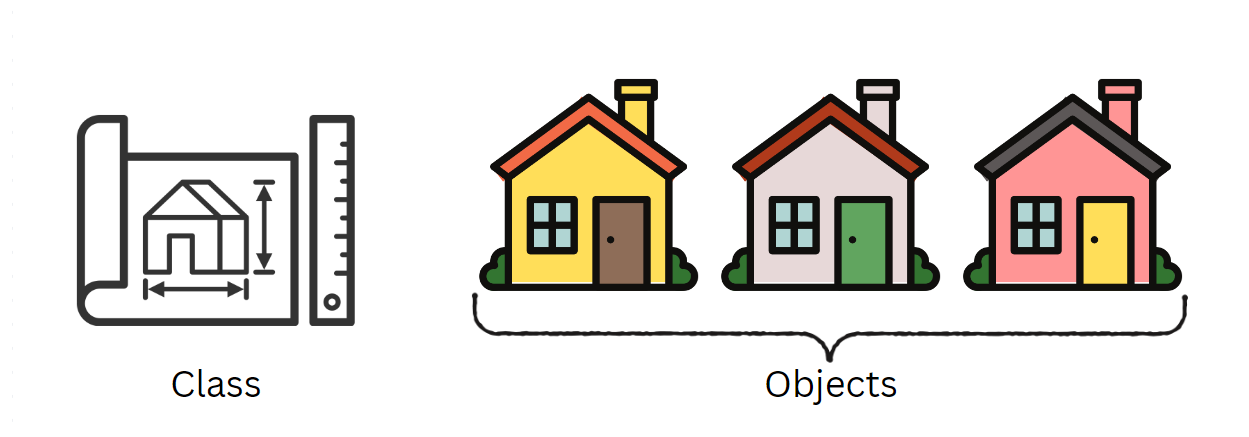

What does this look like in practice? Let's create a very simple class called "Person" which can be used to create a little profile of different people

In [6]:
class Person():

    # instance attribute
    def __init__(self, name, age):
        self.name = name
        self.age = age

This is now our "construction plan/blueprint" - the **class**. Let's use this to create a profile for me - this means we create an **object**.

In [7]:
marla = Person("Marla", 24)

We can now access the attributes of our object - name and age. Remember, we access attributes by typing a "." and the attribute behind our object.

In [8]:
marla.age

24

A class can also contain methods. In our case, we want to know our age in dog years. We can achieve this using this formula:

dog_age = np.exp(1/16 * human_age- 31/16)

In [9]:
import numpy as np

class Person():

    # instance attribute
    def __init__(self, name, age):
        self.name = name
        self.age = age

    # instance method for dog years
    def dog_years(self):
        self.dog_age = np.exp(1/16 * self.age - 31/16)
        print(f"This person is aged {round(self.dog_age, 2)} years in dog years.")

In [12]:
marla = Person("Marla", 24)
marla.dog_years()
marla.dog_age

This person is aged 3.28 years in dog years.


3.2788737679386735

This seems too young to me! If we look at how much this is in months, I would only be about 8 months old.

In [11]:
round(marla.dog_age * 12)

8

You can also try this with your data, just create your own copy - **object** - from the `Person()` **class** we created above :)

### ```dcm2niix``` as a Nipype interface

Above we have converted the DICOM files using the command line. However, we can also run ```dcm2niix``` within Python by using the respective **Nipype** interface.


#### What's Nipype about?

You will learn more about Nipype in the upcoming weeks (and by actualling applying it). For starters, Nipype is an open-source project that allows for integrating a variety of different neuroimaging softwares into a single workflow (and there are *a lot* of different software tools for neuroimaging analysis, like [SPM](https://www.fil.ion.ucl.ac.uk/spm/software/), [FSL](https://fsl.fmrib.ox.ac.uk/fsl/fslwiki) or [AFNI](https://afni.nimh.nih.gov) - just to name a few of them).

In Nipype's context *interfaces* are wrappers that allow Nipype to run programs that are written in languages other than Python (like ```dcm2niix``` for example). This way, we can integrate virtually every available neuroimaging tool within the same environment. You can find a small tutorial on interfaces [here](https://nipype.readthedocs.io/en/0.11.0/users/interface_tutorial.html).

#### Using Nipype to convert dicoms

Before we start using ```dcm2niix``` as a Nipype interface, let's create a new output folder:

In [13]:
!mkdir /content/dicomdata/nifti_nipype

Now we have to import the ```Dcm2niix``` **class** that wraps the functionality of the program within Python.

The ```nipype.interfaces``` module gives us access to several external software packages. You can find a list of all the available packages [here](https://nipype.readthedocs.io/en/latest/api/generated/nipype.interfaces.html).

Now, let's import the ```Dcm2niix``` class from the [dcm2nii module](https://nipype.readthedocs.io/en/latest/api/generated/nipype.interfaces.dcm2nii.html):

In [14]:
from nipype.interfaces.dcm2nii import Dcm2niix

First, let's have a look at the [docstring](https://peps.python.org/pep-0257/) of the ```Dcm2niix``` class (further information can be found in the official [documentation](https://nipype.readthedocs.io/en/latest/api/generated/nipype.interfaces.dcm2nii.html#dcm2niix)):

In [16]:
?Dcm2niix

Note how this info relates to the info we got when running ```dcm2niix``` as a command line tool and by passing the ```-help``` flag.

The first step when using interfaces is always to create an **object** (or: instance) of the respective interface **class** (in this case the ```Dcm2niix``` class):

In [17]:
converter = Dcm2niix()

For ```dcm2niix``` to run we need to provide two mandatory arguments - input and output directory:

In [18]:
converter.inputs.source_dir = "/content/dicomdata/1010_brain_mr_02_lee"
converter.inputs.output_dir = "/content/dicomdata/nifti_nipype"

Besides input and output directory names, there are further (optional) attributes attached to the ```Dcm2niix``` object (you can list all of them by using the command ```print(dir(converter))```).

In [19]:
print(dir(converter))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_additional_metadata', '_always_run', '_can_resume', '_check_mandatory_inputs', '_check_requires', '_check_version_requirements', '_check_xor', '_cmd', '_cmd_prefix', '_duecredit_cite', '_environ', '_etelemetry_version_data', '_filename_from_source', '_format_arg', '_gen_filename', '_get_environ', '_get_filecopy_info', '_ldd', '_list_outputs', '_outputs', '_overload_extension', '_parse_files', '_parse_inputs', '_parse_stdout', '_post_run_hook', '_pre_run_hook', '_redirect_x', '_references', '_run_interface', '_terminal_output', '_version', '_write_cmdline', 'aggregate_outputs', 'always_run', 'can_resume', 'cmd', 'cmdline', 'help', 'ignore_excepti

One attribute that you can find in almost every Nipype class is called ```cmdline```. It basically tells us the way the command will be run on our computer. Remember that Nipype is just a wrapper - "under the hood" ```dcm2niix``` will be run the same way as above when we used it directly as a command line tool. Thus you can think of Nipype as a way to set up these commands within a Python environment (with the main benefit being the ability to integrate a wide variety of different software tools).

Alright, let's have a look at the command that Nipype has created for us:

In [20]:
print(converter.cmdline)

dcm2niix -b y -z y -x n -t n -m n -o /content/dicomdata/nifti_nipype -s n -v n /content/dicomdata/1010_brain_mr_02_lee


Note that there are way more flags included in the command Nipype created compared the one we created ourselves above. This is because a lot of optional functionalities are turned on by default. For example, the attribute ```bids_format``` (which maps to the command line flag ```-b```) is set to ```True``` by default. Check the [documentation](https://nipype.readthedocs.io/en/latest/api/generated/nipype.interfaces.dcm2nii.html#dcm2niix) of the class to see how the different attributes relate to the command line arguments.

Now that we have instantiated our ```Dcm2niix``` object and provided the mandatory inputs we can go ahead and run the interface using the ```run()``` method. This procedure is common to almost all Nipype interface: First, instanstiate the object of a specific interface class, provide mandatory and optional inputs and then actually run it by using the ```run()``` method.

In [21]:
converter.run()

241024-08:30:25,36 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.036322:Chris Rorden's dcm2niiX version v1.0.20211006  (JP2:OpenJPEG) GCC11.2.0 x86-64 (64-bit Linux)


INFO:nipype.interface:stdout 2024-10-24T08:30:25.036322:Chris Rorden's dcm2niiX version v1.0.20211006  (JP2:OpenJPEG) GCC11.2.0 x86-64 (64-bit Linux)


241024-08:30:25,46 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.036322:Found 192 DICOM file(s)


INFO:nipype.interface:stdout 2024-10-24T08:30:25.036322:Found 192 DICOM file(s)


241024-08:30:25,55 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


241024-08:30:25,58 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


241024-08:30:25,61 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


241024-08:30:25,63 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


241024-08:30:25,66 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


241024-08:30:25,68 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


241024-08:30:25,70 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


241024-08:30:25,74 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


241024-08:30:25,76 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


241024-08:30:25,79 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


241024-08:30:25,81 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


241024-08:30:25,84 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


241024-08:30:25,86 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


241024-08:30:25,88 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


241024-08:30:25,89 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


241024-08:30:25,91 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


241024-08:30:25,93 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


241024-08:30:25,95 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


241024-08:30:25,97 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


241024-08:30:25,100 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


241024-08:30:25,101 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


241024-08:30:25,103 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


241024-08:30:25,105 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


241024-08:30:25,107 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


241024-08:30:25,111 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


241024-08:30:25,114 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


241024-08:30:25,116 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


241024-08:30:25,118 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


241024-08:30:25,120 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


241024-08:30:25,122 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


241024-08:30:25,123 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


241024-08:30:25,126 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


241024-08:30:25,129 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


241024-08:30:25,131 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


241024-08:30:25,135 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


241024-08:30:25,137 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


241024-08:30:25,139 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


241024-08:30:25,142 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


241024-08:30:25,148 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


241024-08:30:25,151 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


241024-08:30:25,156 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


241024-08:30:25,165 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


241024-08:30:25,168 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


241024-08:30:25,173 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


241024-08:30:25,181 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


241024-08:30:25,228 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


241024-08:30:25,231 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


241024-08:30:25,253 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


241024-08:30:25,263 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


241024-08:30:25,280 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


241024-08:30:25,292 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


241024-08:30:25,299 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


241024-08:30:25,307 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


241024-08:30:25,314 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


241024-08:30:25,322 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


241024-08:30:25,330 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


241024-08:30:25,338 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


241024-08:30:25,345 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


241024-08:30:25,350 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


241024-08:30:25,357 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


241024-08:30:25,361 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


241024-08:30:25,366 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


241024-08:30:25,376 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


241024-08:30:25,388 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


241024-08:30:25,392 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


241024-08:30:25,396 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


241024-08:30:25,403 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


241024-08:30:25,412 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


241024-08:30:25,421 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


241024-08:30:25,426 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


241024-08:30:25,435 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


241024-08:30:25,441 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


241024-08:30:25,447 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


241024-08:30:25,459 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


241024-08:30:25,463 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


241024-08:30:25,475 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


241024-08:30:25,477 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


241024-08:30:25,491 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


241024-08:30:25,494 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


241024-08:30:25,504 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


241024-08:30:25,514 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


241024-08:30:25,521 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


241024-08:30:25,525 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


241024-08:30:25,529 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


241024-08:30:25,537 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


241024-08:30:25,542 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


241024-08:30:25,546 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


241024-08:30:25,550 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


241024-08:30:25,553 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


241024-08:30:25,558 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


241024-08:30:25,565 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


241024-08:30:25,569 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.036322:Warning: Unknown manufacturer Manufacturer


241024-08:30:25,576 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


241024-08:30:25,582 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


241024-08:30:25,586 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


241024-08:30:25,591 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


241024-08:30:25,598 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


241024-08:30:25,604 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


241024-08:30:25,689 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


241024-08:30:25,708 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


241024-08:30:25,720 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


241024-08:30:25,747 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


241024-08:30:25,785 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


241024-08:30:25,823 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


241024-08:30:25,953 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


241024-08:30:25,955 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


241024-08:30:25,966 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


241024-08:30:25,968 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


241024-08:30:25,978 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


241024-08:30:25,983 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


241024-08:30:25,990 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


241024-08:30:25,999 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


241024-08:30:26,12 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


241024-08:30:26,24 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


241024-08:30:26,36 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


241024-08:30:26,41 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


241024-08:30:26,50 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


241024-08:30:26,63 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


241024-08:30:26,74 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


241024-08:30:26,83 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


241024-08:30:26,97 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


241024-08:30:26,102 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


241024-08:30:26,112 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


241024-08:30:26,126 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


241024-08:30:26,137 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


241024-08:30:26,144 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


241024-08:30:26,153 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


241024-08:30:26,166 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


241024-08:30:26,173 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


241024-08:30:26,186 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


241024-08:30:26,195 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


241024-08:30:26,201 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


241024-08:30:26,210 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


241024-08:30:26,216 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


241024-08:30:26,226 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


241024-08:30:26,230 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


241024-08:30:26,241 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


241024-08:30:26,244 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


241024-08:30:26,252 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


241024-08:30:26,265 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


241024-08:30:26,280 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


241024-08:30:26,286 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


241024-08:30:26,295 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


241024-08:30:26,305 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


241024-08:30:26,317 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


241024-08:30:26,322 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


241024-08:30:26,330 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


241024-08:30:26,339 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


241024-08:30:26,342 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


241024-08:30:26,350 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


241024-08:30:26,361 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


241024-08:30:26,363 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


241024-08:30:26,398 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


241024-08:30:26,457 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


241024-08:30:26,485 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


241024-08:30:26,495 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


241024-08:30:26,514 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


241024-08:30:26,555 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


241024-08:30:26,578 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


241024-08:30:26,642 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


241024-08:30:26,692 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


241024-08:30:26,717 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


241024-08:30:26,720 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


241024-08:30:26,729 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


241024-08:30:26,737 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


241024-08:30:26,739 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


241024-08:30:26,749 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


241024-08:30:26,751 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


241024-08:30:26,759 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


241024-08:30:26,760 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


241024-08:30:26,766 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


241024-08:30:26,778 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


241024-08:30:26,780 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


241024-08:30:26,784 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


241024-08:30:26,790 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


241024-08:30:26,795 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


241024-08:30:26,800 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


241024-08:30:26,805 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


241024-08:30:26,810 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


241024-08:30:26,814 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


241024-08:30:26,819 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


241024-08:30:26,822 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


241024-08:30:26,828 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


241024-08:30:26,831 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


241024-08:30:26,838 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


241024-08:30:26,841 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


241024-08:30:26,845 nipype.interface INFO:
	 stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:25.574133:Warning: Unknown manufacturer Manufacturer


241024-08:30:26,851 nipype.interface INFO:
	 stdout 2024-10-24T08:30:26.851487:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:26.851487:Warning: Unknown manufacturer Manufacturer


241024-08:30:26,855 nipype.interface INFO:
	 stdout 2024-10-24T08:30:26.851487:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:26.851487:Warning: Unknown manufacturer Manufacturer


241024-08:30:26,859 nipype.interface INFO:
	 stdout 2024-10-24T08:30:26.851487:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:26.851487:Warning: Unknown manufacturer Manufacturer


241024-08:30:26,863 nipype.interface INFO:
	 stdout 2024-10-24T08:30:26.851487:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:26.851487:Warning: Unknown manufacturer Manufacturer


241024-08:30:26,867 nipype.interface INFO:
	 stdout 2024-10-24T08:30:26.851487:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T08:30:26.851487:Warning: Unknown manufacturer Manufacturer


241024-08:30:26,871 nipype.interface INFO:
	 stdout 2024-10-24T08:30:26.851487:Warning: Unable to determine manufacturer (0008,0070), so conversion is not tuned for vendor.


INFO:nipype.interface:stdout 2024-10-24T08:30:26.851487:Warning: Unable to determine manufacturer (0008,0070), so conversion is not tuned for vendor.


241024-08:30:26,875 nipype.interface INFO:
	 stdout 2024-10-24T08:30:26.851487:Convert 192 DICOM as /content/dicomdata/nifti_nipype/1010_brain_mr_02_lee_T1_AX_20080801000000_2 (192x256x192x1)


INFO:nipype.interface:stdout 2024-10-24T08:30:26.851487:Convert 192 DICOM as /content/dicomdata/nifti_nipype/1010_brain_mr_02_lee_T1_AX_20080801000000_2 (192x256x192x1)


241024-08:30:28,431 nipype.interface INFO:
	 stdout 2024-10-24T08:30:28.431337:Compress: "/usr/bin/pigz" -b 960 -n -f -6 "/content/dicomdata/nifti_nipype/1010_brain_mr_02_lee_T1_AX_20080801000000_2.nii"


INFO:nipype.interface:stdout 2024-10-24T08:30:28.431337:Compress: "/usr/bin/pigz" -b 960 -n -f -6 "/content/dicomdata/nifti_nipype/1010_brain_mr_02_lee_T1_AX_20080801000000_2.nii"


241024-08:30:28,437 nipype.interface INFO:
	 stdout 2024-10-24T08:30:28.431337:Conversion required 3.447670 seconds (0.297380 for core code).


INFO:nipype.interface:stdout 2024-10-24T08:30:28.431337:Conversion required 3.447670 seconds (0.297380 for core code).


Have a look at Colab's (or your local machine's) file browser to see whether a ```.nii```/```.nii.gz``` has been created in the output directory.

## Exercise

First, in the dicomdata directory, create a new output directory called ```nifti-nipype-2```. Then, convert the dicom files using the Nipype interface and store the results in the newly created directory. For this job, use an compression level of 5 (Tip: you can have a look at the documentation using ```?Dcm2niix``` to find the appropriate option).

Finally, plot the NIfTI file using Nilearn (we did this in the first session - if you need a refresher, check out the notebook).

In [23]:
!mkdir /content/dicomdata/nifti_nipype-2

from nipype.interfaces.dcm2nii import Dcm2niix

convert = Dcm2niix()
convert.inputs.source_dir = "/content/dicomdata/1010_brain_mr_02_lee"
convert.inputs.output_dir = "/content/dicomdata/nifti_nipype-2"
convert.inputs.compression = 5

convert.run()


241024-09:02:40,666 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.666010:Chris Rorden's dcm2niiX version v1.0.20211006  (JP2:OpenJPEG) GCC11.2.0 x86-64 (64-bit Linux)


INFO:nipype.interface:stdout 2024-10-24T09:02:40.666010:Chris Rorden's dcm2niiX version v1.0.20211006  (JP2:OpenJPEG) GCC11.2.0 x86-64 (64-bit Linux)


241024-09:02:40,670 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.666010:Found 192 DICOM file(s)


INFO:nipype.interface:stdout 2024-10-24T09:02:40.666010:Found 192 DICOM file(s)


241024-09:02:40,672 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


241024-09:02:40,674 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


241024-09:02:40,676 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


241024-09:02:40,679 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


241024-09:02:40,681 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


241024-09:02:40,683 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


241024-09:02:40,685 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


241024-09:02:40,687 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


241024-09:02:40,689 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


241024-09:02:40,691 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


241024-09:02:40,693 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


241024-09:02:40,696 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


241024-09:02:40,698 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


241024-09:02:40,700 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


241024-09:02:40,702 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


241024-09:02:40,707 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


241024-09:02:40,709 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


241024-09:02:40,712 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


241024-09:02:40,714 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


241024-09:02:40,716 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


241024-09:02:40,718 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


241024-09:02:40,720 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


241024-09:02:40,722 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


241024-09:02:40,724 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


241024-09:02:40,733 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


241024-09:02:40,736 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


241024-09:02:40,742 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


241024-09:02:40,748 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


241024-09:02:40,750 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


241024-09:02:40,756 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


241024-09:02:40,760 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


241024-09:02:40,767 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


241024-09:02:40,772 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


241024-09:02:40,775 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


241024-09:02:40,781 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


241024-09:02:40,783 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


241024-09:02:40,788 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


241024-09:02:40,790 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


241024-09:02:40,795 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


241024-09:02:40,800 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


241024-09:02:40,804 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


241024-09:02:40,806 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


241024-09:02:40,811 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


241024-09:02:40,815 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


241024-09:02:40,817 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


241024-09:02:40,822 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


241024-09:02:40,828 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


241024-09:02:40,830 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


241024-09:02:40,837 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


241024-09:02:40,839 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


241024-09:02:40,842 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


241024-09:02:40,846 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


241024-09:02:40,849 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


241024-09:02:40,852 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


241024-09:02:40,858 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


241024-09:02:40,860 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


241024-09:02:40,863 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


241024-09:02:40,866 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


241024-09:02:40,870 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


241024-09:02:40,873 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


241024-09:02:40,876 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


241024-09:02:40,880 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


241024-09:02:40,886 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


241024-09:02:40,888 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


241024-09:02:40,891 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


241024-09:02:40,896 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


241024-09:02:40,900 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


241024-09:02:40,903 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


241024-09:02:40,908 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


241024-09:02:40,911 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


241024-09:02:40,915 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


241024-09:02:40,920 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


241024-09:02:40,922 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


241024-09:02:40,926 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


241024-09:02:40,930 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


241024-09:02:40,935 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


241024-09:02:40,937 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


241024-09:02:40,943 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


241024-09:02:40,945 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


241024-09:02:40,947 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


241024-09:02:40,952 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


241024-09:02:40,957 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


241024-09:02:40,959 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


241024-09:02:40,961 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


241024-09:02:40,967 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


241024-09:02:40,969 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


241024-09:02:40,973 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


241024-09:02:40,975 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


241024-09:02:40,981 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


241024-09:02:40,983 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


241024-09:02:40,985 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


241024-09:02:40,987 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.666010:Warning: Unknown manufacturer Manufacturer


241024-09:02:40,993 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


241024-09:02:40,995 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


241024-09:02:41,0 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


241024-09:02:41,2 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


241024-09:02:41,8 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


241024-09:02:41,10 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


241024-09:02:41,12 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


241024-09:02:41,20 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


241024-09:02:41,23 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


241024-09:02:41,25 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


241024-09:02:41,66 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


241024-09:02:41,84 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


241024-09:02:41,92 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


241024-09:02:41,103 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


241024-09:02:41,159 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


241024-09:02:41,168 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


241024-09:02:41,213 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


241024-09:02:41,217 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


241024-09:02:41,227 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


241024-09:02:41,235 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


241024-09:02:41,248 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


241024-09:02:41,252 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


241024-09:02:41,261 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


241024-09:02:41,274 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


241024-09:02:41,283 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


241024-09:02:41,292 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


241024-09:02:41,300 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


241024-09:02:41,312 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


241024-09:02:41,324 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


241024-09:02:41,332 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


241024-09:02:41,338 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


241024-09:02:41,351 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


241024-09:02:41,371 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


241024-09:02:41,378 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


241024-09:02:41,386 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


241024-09:02:41,395 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


241024-09:02:41,411 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


241024-09:02:41,413 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


241024-09:02:41,422 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


241024-09:02:41,436 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


241024-09:02:41,447 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


241024-09:02:41,465 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


241024-09:02:41,482 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


241024-09:02:41,492 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


241024-09:02:41,499 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


241024-09:02:41,509 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


241024-09:02:41,522 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


241024-09:02:41,529 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


241024-09:02:41,540 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


241024-09:02:41,554 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


241024-09:02:41,560 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


241024-09:02:41,570 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


241024-09:02:41,583 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


241024-09:02:41,591 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


241024-09:02:41,609 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


241024-09:02:41,623 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


241024-09:02:41,634 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


241024-09:02:41,652 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


241024-09:02:41,663 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


241024-09:02:41,674 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


241024-09:02:41,682 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


241024-09:02:41,693 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


241024-09:02:41,708 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


241024-09:02:41,721 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


241024-09:02:41,729 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


241024-09:02:41,735 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


241024-09:02:41,746 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


241024-09:02:41,756 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


241024-09:02:41,769 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


241024-09:02:41,778 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


241024-09:02:41,791 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


241024-09:02:41,794 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


241024-09:02:41,803 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


241024-09:02:41,815 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


241024-09:02:41,826 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


241024-09:02:41,836 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


241024-09:02:41,844 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


241024-09:02:41,853 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


241024-09:02:41,864 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


241024-09:02:41,875 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


241024-09:02:41,886 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


241024-09:02:41,891 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


241024-09:02:41,901 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


241024-09:02:41,907 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


241024-09:02:41,916 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


241024-09:02:41,932 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


241024-09:02:41,944 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


241024-09:02:41,946 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


241024-09:02:41,965 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


241024-09:02:41,969 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


241024-09:02:41,983 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


241024-09:02:41,989 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


241024-09:02:42,2 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


241024-09:02:42,9 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


241024-09:02:42,18 nipype.interface INFO:
	 stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:40.992931:Warning: Unknown manufacturer Manufacturer


241024-09:02:42,24 nipype.interface INFO:
	 stdout 2024-10-24T09:02:42.024476:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:42.024476:Warning: Unknown manufacturer Manufacturer


241024-09:02:42,34 nipype.interface INFO:
	 stdout 2024-10-24T09:02:42.024476:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:42.024476:Warning: Unknown manufacturer Manufacturer


241024-09:02:42,40 nipype.interface INFO:
	 stdout 2024-10-24T09:02:42.024476:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:42.024476:Warning: Unknown manufacturer Manufacturer


241024-09:02:42,50 nipype.interface INFO:
	 stdout 2024-10-24T09:02:42.024476:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:42.024476:Warning: Unknown manufacturer Manufacturer


241024-09:02:42,63 nipype.interface INFO:
	 stdout 2024-10-24T09:02:42.024476:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:02:42.024476:Warning: Unknown manufacturer Manufacturer


241024-09:02:42,69 nipype.interface INFO:
	 stdout 2024-10-24T09:02:42.024476:Warning: Unable to determine manufacturer (0008,0070), so conversion is not tuned for vendor.


INFO:nipype.interface:stdout 2024-10-24T09:02:42.024476:Warning: Unable to determine manufacturer (0008,0070), so conversion is not tuned for vendor.


241024-09:02:42,79 nipype.interface INFO:
	 stdout 2024-10-24T09:02:42.024476:Convert 192 DICOM as /content/dicomdata/nifti_nipype-2/1010_brain_mr_02_lee_T1_AX_20080801000000_2 (192x256x192x1)


INFO:nipype.interface:stdout 2024-10-24T09:02:42.024476:Convert 192 DICOM as /content/dicomdata/nifti_nipype-2/1010_brain_mr_02_lee_T1_AX_20080801000000_2 (192x256x192x1)


241024-09:02:42,966 nipype.interface INFO:
	 stdout 2024-10-24T09:02:42.966516:Compress: "/usr/bin/pigz" -b 960 -n -f -5 "/content/dicomdata/nifti_nipype-2/1010_brain_mr_02_lee_T1_AX_20080801000000_2.nii"


INFO:nipype.interface:stdout 2024-10-24T09:02:42.966516:Compress: "/usr/bin/pigz" -b 960 -n -f -5 "/content/dicomdata/nifti_nipype-2/1010_brain_mr_02_lee_T1_AX_20080801000000_2.nii"


241024-09:02:42,973 nipype.interface INFO:
	 stdout 2024-10-24T09:02:42.966516:Conversion required 2.346823 seconds (0.249711 for core code).


INFO:nipype.interface:stdout 2024-10-24T09:02:42.966516:Conversion required 2.346823 seconds (0.249711 for core code).


/usr/local/lib/python3.10/dist-packages/nilearn/image/resampling.py:809: UserWarning: Casting data from int32 to float32
  return resample_img(


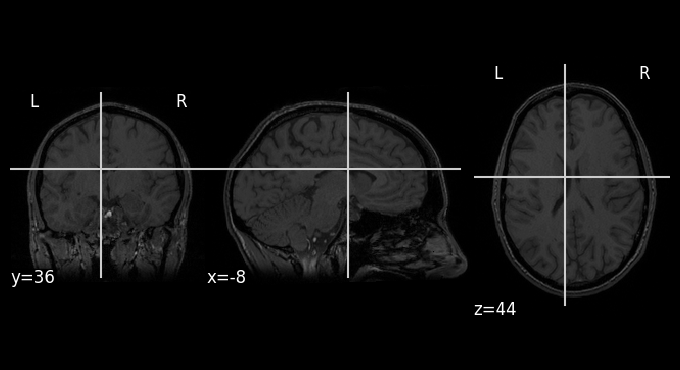

In [25]:
from nilearn import plotting

plotting.plot_anat("/content/dicomdata/nifti_nipype-2/1010_brain_mr_02_lee_T1_AX_20080801000000_2.nii.gz")

## Bonus Exercise

Create your own class that has a method which converts dicom files to nifti format (using the Nipype wrapper). It should take input and output path as arugments. It should also contain a method which plots the resulting nifti file. Tip: the dcm2niix objects have an attribute called `output_files` :)


In [27]:
class ConvertPlot():

    def __init__(self, input_path, output_path):
        self.input_path = input_path
        self.output_path = output_path

        convert = Dcm2niix()
        convert.inputs.source_dir = self.input_path
        convert.inputs.output_dir = self.output_path
        convert.run()
        self.nifti_path = convert.output_files

    def plot(self):
        plotting.plot_anat(self.nifti_path[0])

241024-09:14:44,444 nipype.interface INFO:
	 stdout 2024-10-24T09:14:44.444197:Chris Rorden's dcm2niiX version v1.0.20211006  (JP2:OpenJPEG) GCC11.2.0 x86-64 (64-bit Linux)


INFO:nipype.interface:stdout 2024-10-24T09:14:44.444197:Chris Rorden's dcm2niiX version v1.0.20211006  (JP2:OpenJPEG) GCC11.2.0 x86-64 (64-bit Linux)


241024-09:14:44,452 nipype.interface INFO:
	 stdout 2024-10-24T09:14:44.444197:Found 192 DICOM file(s)


INFO:nipype.interface:stdout 2024-10-24T09:14:44.444197:Found 192 DICOM file(s)


241024-09:14:44,461 nipype.interface INFO:
	 stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


241024-09:14:44,469 nipype.interface INFO:
	 stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


241024-09:14:44,477 nipype.interface INFO:
	 stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


241024-09:14:44,485 nipype.interface INFO:
	 stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


241024-09:14:44,493 nipype.interface INFO:
	 stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


241024-09:14:44,500 nipype.interface INFO:
	 stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


241024-09:14:44,512 nipype.interface INFO:
	 stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


241024-09:14:44,514 nipype.interface INFO:
	 stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


241024-09:14:44,524 nipype.interface INFO:
	 stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


241024-09:14:44,544 nipype.interface INFO:
	 stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


241024-09:14:44,559 nipype.interface INFO:
	 stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


241024-09:14:44,564 nipype.interface INFO:
	 stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


241024-09:14:44,568 nipype.interface INFO:
	 stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


241024-09:14:44,573 nipype.interface INFO:
	 stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


241024-09:14:44,578 nipype.interface INFO:
	 stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


241024-09:14:44,586 nipype.interface INFO:
	 stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


241024-09:14:44,588 nipype.interface INFO:
	 stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


241024-09:14:44,590 nipype.interface INFO:
	 stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


241024-09:14:44,596 nipype.interface INFO:
	 stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


241024-09:14:44,598 nipype.interface INFO:
	 stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


241024-09:14:44,604 nipype.interface INFO:
	 stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


241024-09:14:44,606 nipype.interface INFO:
	 stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


241024-09:14:44,612 nipype.interface INFO:
	 stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


241024-09:14:44,614 nipype.interface INFO:
	 stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


241024-09:14:44,618 nipype.interface INFO:
	 stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


241024-09:14:44,623 nipype.interface INFO:
	 stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


241024-09:14:44,627 nipype.interface INFO:
	 stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


241024-09:14:44,631 nipype.interface INFO:
	 stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


241024-09:14:44,635 nipype.interface INFO:
	 stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


241024-09:14:44,639 nipype.interface INFO:
	 stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


241024-09:14:44,643 nipype.interface INFO:
	 stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


241024-09:14:44,647 nipype.interface INFO:
	 stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


241024-09:14:44,651 nipype.interface INFO:
	 stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


241024-09:14:44,662 nipype.interface INFO:
	 stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


241024-09:14:44,666 nipype.interface INFO:
	 stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


241024-09:14:44,672 nipype.interface INFO:
	 stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


241024-09:14:44,678 nipype.interface INFO:
	 stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


241024-09:14:44,682 nipype.interface INFO:
	 stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


241024-09:14:44,690 nipype.interface INFO:
	 stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


241024-09:14:44,696 nipype.interface INFO:
	 stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


241024-09:14:44,701 nipype.interface INFO:
	 stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


241024-09:14:44,710 nipype.interface INFO:
	 stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


241024-09:14:44,716 nipype.interface INFO:
	 stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


241024-09:14:44,722 nipype.interface INFO:
	 stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


241024-09:14:44,726 nipype.interface INFO:
	 stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


241024-09:14:44,733 nipype.interface INFO:
	 stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


241024-09:14:44,739 nipype.interface INFO:
	 stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


241024-09:14:44,744 nipype.interface INFO:
	 stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


241024-09:14:44,748 nipype.interface INFO:
	 stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


241024-09:14:44,753 nipype.interface INFO:
	 stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


241024-09:14:44,762 nipype.interface INFO:
	 stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


241024-09:14:44,771 nipype.interface INFO:
	 stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


241024-09:14:44,777 nipype.interface INFO:
	 stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


241024-09:14:44,779 nipype.interface INFO:
	 stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


241024-09:14:44,785 nipype.interface INFO:
	 stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


241024-09:14:44,792 nipype.interface INFO:
	 stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


241024-09:14:44,796 nipype.interface INFO:
	 stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


241024-09:14:44,801 nipype.interface INFO:
	 stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


241024-09:14:44,812 nipype.interface INFO:
	 stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


241024-09:14:44,825 nipype.interface INFO:
	 stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


241024-09:14:44,836 nipype.interface INFO:
	 stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


241024-09:14:44,847 nipype.interface INFO:
	 stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


241024-09:14:44,855 nipype.interface INFO:
	 stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


241024-09:14:44,861 nipype.interface INFO:
	 stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


241024-09:14:44,868 nipype.interface INFO:
	 stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


241024-09:14:44,873 nipype.interface INFO:
	 stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


241024-09:14:44,882 nipype.interface INFO:
	 stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


241024-09:14:44,887 nipype.interface INFO:
	 stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


241024-09:14:44,891 nipype.interface INFO:
	 stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


241024-09:14:44,896 nipype.interface INFO:
	 stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


241024-09:14:44,907 nipype.interface INFO:
	 stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


241024-09:14:44,911 nipype.interface INFO:
	 stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


241024-09:14:44,919 nipype.interface INFO:
	 stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


241024-09:14:44,922 nipype.interface INFO:
	 stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


241024-09:14:44,930 nipype.interface INFO:
	 stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


241024-09:14:44,936 nipype.interface INFO:
	 stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


241024-09:14:44,942 nipype.interface INFO:
	 stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


241024-09:14:44,948 nipype.interface INFO:
	 stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


241024-09:14:44,960 nipype.interface INFO:
	 stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


241024-09:14:44,962 nipype.interface INFO:
	 stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


241024-09:14:44,976 nipype.interface INFO:
	 stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


241024-09:14:44,979 nipype.interface INFO:
	 stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


241024-09:14:44,984 nipype.interface INFO:
	 stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


241024-09:14:44,993 nipype.interface INFO:
	 stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


241024-09:14:45,0 nipype.interface INFO:
	 stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


241024-09:14:45,7 nipype.interface INFO:
	 stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


241024-09:14:45,20 nipype.interface INFO:
	 stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


241024-09:14:45,24 nipype.interface INFO:
	 stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


241024-09:14:45,32 nipype.interface INFO:
	 stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


241024-09:14:45,39 nipype.interface INFO:
	 stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


241024-09:14:45,49 nipype.interface INFO:
	 stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


241024-09:14:45,61 nipype.interface INFO:
	 stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:44.444197:Warning: Unknown manufacturer Manufacturer


241024-09:14:45,63 nipype.interface INFO:
	 stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


241024-09:14:45,72 nipype.interface INFO:
	 stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


241024-09:14:45,81 nipype.interface INFO:
	 stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


241024-09:14:45,88 nipype.interface INFO:
	 stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


241024-09:14:45,96 nipype.interface INFO:
	 stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


241024-09:14:45,104 nipype.interface INFO:
	 stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


241024-09:14:45,113 nipype.interface INFO:
	 stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


241024-09:14:45,120 nipype.interface INFO:
	 stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


241024-09:14:45,128 nipype.interface INFO:
	 stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


241024-09:14:45,136 nipype.interface INFO:
	 stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


241024-09:14:45,142 nipype.interface INFO:
	 stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


241024-09:14:45,151 nipype.interface INFO:
	 stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


241024-09:14:45,159 nipype.interface INFO:
	 stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


241024-09:14:45,166 nipype.interface INFO:
	 stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


241024-09:14:45,177 nipype.interface INFO:
	 stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


241024-09:14:45,182 nipype.interface INFO:
	 stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


241024-09:14:45,191 nipype.interface INFO:
	 stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


241024-09:14:45,202 nipype.interface INFO:
	 stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


241024-09:14:45,208 nipype.interface INFO:
	 stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


241024-09:14:45,217 nipype.interface INFO:
	 stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


241024-09:14:45,227 nipype.interface INFO:
	 stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


241024-09:14:45,233 nipype.interface INFO:
	 stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


241024-09:14:45,239 nipype.interface INFO:
	 stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


241024-09:14:45,252 nipype.interface INFO:
	 stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


241024-09:14:45,260 nipype.interface INFO:
	 stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


241024-09:14:45,265 nipype.interface INFO:
	 stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


241024-09:14:45,276 nipype.interface INFO:
	 stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


241024-09:14:45,283 nipype.interface INFO:
	 stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


241024-09:14:45,291 nipype.interface INFO:
	 stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


241024-09:14:45,304 nipype.interface INFO:
	 stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


241024-09:14:45,309 nipype.interface INFO:
	 stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


241024-09:14:45,318 nipype.interface INFO:
	 stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


241024-09:14:45,326 nipype.interface INFO:
	 stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


241024-09:14:45,332 nipype.interface INFO:
	 stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


241024-09:14:45,342 nipype.interface INFO:
	 stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


241024-09:14:45,349 nipype.interface INFO:
	 stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


241024-09:14:45,359 nipype.interface INFO:
	 stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


241024-09:14:45,371 nipype.interface INFO:
	 stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


241024-09:14:45,386 nipype.interface INFO:
	 stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


241024-09:14:45,394 nipype.interface INFO:
	 stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


241024-09:14:45,405 nipype.interface INFO:
	 stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


241024-09:14:45,420 nipype.interface INFO:
	 stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


241024-09:14:45,435 nipype.interface INFO:
	 stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


241024-09:14:45,453 nipype.interface INFO:
	 stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


241024-09:14:45,464 nipype.interface INFO:
	 stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


241024-09:14:45,476 nipype.interface INFO:
	 stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


241024-09:14:45,482 nipype.interface INFO:
	 stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


241024-09:14:45,498 nipype.interface INFO:
	 stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


241024-09:14:45,522 nipype.interface INFO:
	 stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


241024-09:14:45,535 nipype.interface INFO:
	 stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


241024-09:14:45,548 nipype.interface INFO:
	 stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


241024-09:14:45,559 nipype.interface INFO:
	 stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


241024-09:14:45,568 nipype.interface INFO:
	 stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


241024-09:14:45,582 nipype.interface INFO:
	 stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


241024-09:14:45,590 nipype.interface INFO:
	 stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


241024-09:14:45,606 nipype.interface INFO:
	 stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


241024-09:14:45,635 nipype.interface INFO:
	 stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


241024-09:14:45,642 nipype.interface INFO:
	 stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


241024-09:14:45,658 nipype.interface INFO:
	 stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


241024-09:14:45,693 nipype.interface INFO:
	 stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


241024-09:14:45,703 nipype.interface INFO:
	 stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


241024-09:14:45,718 nipype.interface INFO:
	 stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


241024-09:14:45,732 nipype.interface INFO:
	 stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


241024-09:14:45,799 nipype.interface INFO:
	 stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


241024-09:14:45,831 nipype.interface INFO:
	 stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


241024-09:14:45,885 nipype.interface INFO:
	 stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


241024-09:14:45,898 nipype.interface INFO:
	 stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


241024-09:14:45,904 nipype.interface INFO:
	 stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


241024-09:14:45,914 nipype.interface INFO:
	 stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


241024-09:14:45,927 nipype.interface INFO:
	 stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


241024-09:14:45,933 nipype.interface INFO:
	 stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


241024-09:14:45,944 nipype.interface INFO:
	 stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


241024-09:14:45,946 nipype.interface INFO:
	 stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


241024-09:14:45,956 nipype.interface INFO:
	 stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


241024-09:14:45,963 nipype.interface INFO:
	 stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


241024-09:14:45,976 nipype.interface INFO:
	 stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


241024-09:14:45,983 nipype.interface INFO:
	 stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


241024-09:14:46,0 nipype.interface INFO:
	 stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


241024-09:14:46,13 nipype.interface INFO:
	 stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


241024-09:14:46,23 nipype.interface INFO:
	 stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


241024-09:14:46,35 nipype.interface INFO:
	 stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


241024-09:14:46,42 nipype.interface INFO:
	 stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


241024-09:14:46,52 nipype.interface INFO:
	 stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


241024-09:14:46,61 nipype.interface INFO:
	 stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


241024-09:14:46,70 nipype.interface INFO:
	 stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


241024-09:14:46,79 nipype.interface INFO:
	 stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


241024-09:14:46,89 nipype.interface INFO:
	 stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


241024-09:14:46,99 nipype.interface INFO:
	 stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


241024-09:14:46,111 nipype.interface INFO:
	 stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


241024-09:14:46,121 nipype.interface INFO:
	 stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


241024-09:14:46,132 nipype.interface INFO:
	 stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


241024-09:14:46,143 nipype.interface INFO:
	 stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


241024-09:14:46,154 nipype.interface INFO:
	 stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


241024-09:14:46,171 nipype.interface INFO:
	 stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


241024-09:14:46,176 nipype.interface INFO:
	 stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:45.063723:Warning: Unknown manufacturer Manufacturer


241024-09:14:46,200 nipype.interface INFO:
	 stdout 2024-10-24T09:14:46.200143:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:46.200143:Warning: Unknown manufacturer Manufacturer


241024-09:14:46,205 nipype.interface INFO:
	 stdout 2024-10-24T09:14:46.200143:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:46.200143:Warning: Unknown manufacturer Manufacturer


241024-09:14:46,212 nipype.interface INFO:
	 stdout 2024-10-24T09:14:46.200143:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:46.200143:Warning: Unknown manufacturer Manufacturer


241024-09:14:46,221 nipype.interface INFO:
	 stdout 2024-10-24T09:14:46.200143:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:46.200143:Warning: Unknown manufacturer Manufacturer


241024-09:14:46,231 nipype.interface INFO:
	 stdout 2024-10-24T09:14:46.200143:Warning: Unknown manufacturer Manufacturer


INFO:nipype.interface:stdout 2024-10-24T09:14:46.200143:Warning: Unknown manufacturer Manufacturer


241024-09:14:46,241 nipype.interface INFO:
	 stdout 2024-10-24T09:14:46.200143:Warning: Unable to determine manufacturer (0008,0070), so conversion is not tuned for vendor.


INFO:nipype.interface:stdout 2024-10-24T09:14:46.200143:Warning: Unable to determine manufacturer (0008,0070), so conversion is not tuned for vendor.


241024-09:14:46,250 nipype.interface INFO:
	 stdout 2024-10-24T09:14:46.200143:Convert 192 DICOM as /content/dicomdata/nifti_nipype-3/1010_brain_mr_02_lee_T1_AX_20080801000000_2b (192x256x192x1)


INFO:nipype.interface:stdout 2024-10-24T09:14:46.200143:Convert 192 DICOM as /content/dicomdata/nifti_nipype-3/1010_brain_mr_02_lee_T1_AX_20080801000000_2b (192x256x192x1)


241024-09:14:47,450 nipype.interface INFO:
	 stdout 2024-10-24T09:14:47.450321:Compress: "/usr/bin/pigz" -b 960 -n -f -6 "/content/dicomdata/nifti_nipype-3/1010_brain_mr_02_lee_T1_AX_20080801000000_2b.nii"


INFO:nipype.interface:stdout 2024-10-24T09:14:47.450321:Compress: "/usr/bin/pigz" -b 960 -n -f -6 "/content/dicomdata/nifti_nipype-3/1010_brain_mr_02_lee_T1_AX_20080801000000_2b.nii"


241024-09:14:47,453 nipype.interface INFO:
	 stdout 2024-10-24T09:14:47.450321:Conversion required 3.052777 seconds (0.238919 for core code).


INFO:nipype.interface:stdout 2024-10-24T09:14:47.450321:Conversion required 3.052777 seconds (0.238919 for core code).
/usr/local/lib/python3.10/dist-packages/nilearn/image/resampling.py:809: UserWarning: Casting data from int32 to float32
  return resample_img(


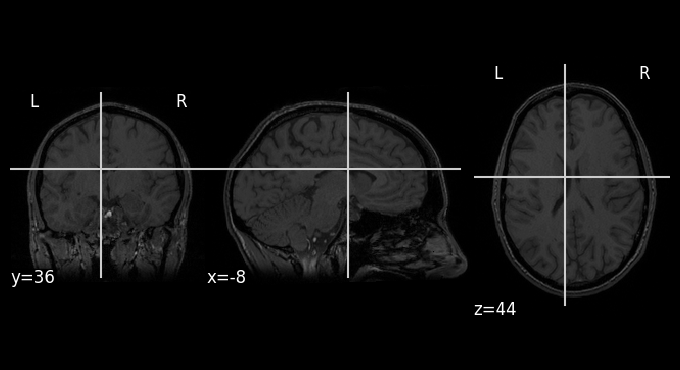

In [28]:
test1 = ConvertPlot("/content/dicomdata/1010_brain_mr_02_lee", "/content/dicomdata/nifti_nipype-3")
test1.plot()

## Resources

[The NIFTI file format](https://brainder.org/2012/09/23/the-nifti-file-format/): Comprehensive overview of the contents of the Nifti file format

[MRI analysis in Python using Nipype, Nilearn and more](https://peerherholz.github.io/workshop_weizmann/index.html): Very neat Jupyter book covering different aspects of MRI analysis in Python (by [by Peer Herholz](https://peerherholz.github.io)). Also includes a nice [presentation](https://docs.google.com/presentation/d/e/2PACX-1vSuwfkKyYh0qMZzRO4vM0lG6A2XGA_JxQxGl1Cw_wSyK40jaceCg-emUJQxB-49VMMcAXadd4WKgMJv/embed?start=false&amp;loop=false&amp;delayms=3000&amp;usp=embed_facebook&slide=id.g8074ffaf2c_0_0) on Nipype and the ecosystem around it

[Dartbrains](https://dartbrains.org/content/intro.html): Very comprehensive course on fMRI analysis using Python, covering mathematical/statistical fundamentals (by [Luke Chang](http://www.lukejchang.com))

[NiPraxis](https://textbook.nipraxis.org/intro.html): Another course going very deep and covering both practise and theory of brain imaging.

[Neuroimaging and Data Science](https://neuroimaging-data-science.org/root.html): "Introduction to contemporary data science and its application in neuroimaging research" (by Ariel Rokem & Tal Yarkoni). Again, going way deeper than the scope of our course.

## References

Michael Joseph, Jerrold Jeyachandra, and Erin Dickie (eds):
"Data Carpentry: Introduction to MRI Data Analysis." Version 2019.11, November 2019,
https://github.com/carpentries-incubator/SDC-BIDS-IntroMRI
